In [1]:
# Manipulação:
import pandas as pd
import numpy as np
from datetime import datetime

# Estatística
import statistics as sts
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Gráficos:
import matplotlib.pylab as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Codificação dos atributos categóricos:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from sklearn.compose import make_column_transformer

# Dividir os dados entre treino e teste:
from sklearn.model_selection import train_test_split

# Modelos:
# NaiveBayes:
from sklearn.naive_bayes import GaussianNB

# Árvores de Decisão:
from sklearn.tree import DecisionTreeClassifier

# Support Vector Machine:
from sklearn.svm import SVC

# RandomForest:
from sklearn.ensemble import RandomForestClassifier

# KNN:
from sklearn.neighbors import KNeighborsClassifier

# XGBoost:
from xgboost import XGBClassifier

# Rede Neural Perceptron Multicamadas:
from keras.models import Sequential
from keras.layers import Dense

# Métricas de desempenho:
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
#Carregamento das bases:
dfClientes = pd.read_csv("caso_estudo_clientes.csv", sep=";")
dfLojas = pd.read_csv("caso_estudo_lojas.csv", sep=";")
dfPg = pd.read_csv("caso_estudo_pagamentos.csv", sep=";")
dfProdutos = pd.read_csv("caso_estudo_produtos.csv", sep=";")
dfVendas = pd.read_csv("caso_estudo_vendas.csv", sep=";")

# 1 Data Clean:

## 1.1 Dados Nulos:

In [3]:
#Dados Nulos Identificação:

#Clientes possuem 10 registros nulos:
dfClientes[dfClientes.isnull().T.any()]

#Lojas possuem 0 registros nulos:
dfLojas[dfLojas.isnull().T.any()]

#Pgtos possuem 12 registros nulos:
dfPg.isnull().sum()

#Produtos possuem 0 registros nulos:
dfProdutos[dfProdutos.isnull().T.any()]

#Vendas possuem 0 registros nulos:
dfVendas.isnull().sum()

id            0
id_cliente    0
id_loja       0
id_produto    0
dt_venda      0
dtype: int64

In [4]:
#Dados Nulos Correção:

#Clientes: Podemos excluir os registros de clientes com dados nulos?
id_cliente_nulos = dfClientes[dfClientes.isnull().T.any()]["id"].values
n_vendas_cliente_nulos = dfVendas[dfVendas["id_cliente"].isin(id_cliente_nulos)]["id_cliente"].values

#Número de clientes com dados nulos: Existem 10 clientes com daodos nulos
id_cliente_nulos.shape

#Esses clientes afetam 12 vendas de um total de 1000
n_vendas_cliente_nulos.shape

#Portanto, podemos excluir os clientes nulos e as vendas afetadas por eles.
dfClientes.drop(dfClientes[dfClientes.isnull().T.any()].index, inplace=True)

#Pagamentos: Podemos excluir os registros de pagamentos com dados nulos?
dfPg[dfPg.isnull().T.any()]

#Neste caso vamos excluir, pois o próprio id é nulo, o que resulta num registro nulo nas vendas
dfPg.drop(dfPg[dfPg.isnull().T.any()].index, inplace=True)

## 1.2 Dados Duplicados:

In [5]:
#Dados Duplicados Identificação:

#Clientes possuem 0 registros duplicados:
dfClientes.drop("id", axis=1).duplicated().sum()

#Lojas possuem 0 registros duplicados:
dfLojas.drop("id", axis=1).duplicated().sum()

#Pgto possuem 0 registros duplicados:
dfPg.drop("id", axis=1).duplicated().sum()

#Produtos possuem 0 registros duplicados:
dfProdutos.drop("id", axis=1).duplicated().sum()

#Vendas possum 0  dados duplicados:
dfVendas.drop("id", axis=1).duplicated().sum()

0

## 1.3 Dados Incosistentes: Formato dados, fora das regras de negócio e outliers.

In [6]:
#Identificação dos Dados Incosistentes:

#Clientes: Corrigir formato da data de nascimento.
dfClientes.id.describe()
dfClientes.sexo.unique()
dfClientes.dtypes

#Lojas: OK.
dfLojas.id.describe()
dfLojas.cidade.unique()

#Pgto: Corrigir formato da data de pagamento.
dfPg.describe()
dfPg.dtypes

#Produtos: Corrigir produto com valor exorbitante e nome ilegível.
dfProdutos.describe() #Produto mais caro na ordem de 3 milhôes.
dfProdutos.produto.unique() #Produto com nome ilegível.

#Vendas: Corrigir formato da data da venda.
dfVendas.describe()

,id,id_cliente,id_loja,id_produto
count,1000.000000,1000.00000,1000.000000,1000.00000
mean,500.500000,504.88600,5.439000,5.56700
std,288.819436,291.43546,2.870631,2.90447
min,1.000000,1.00000,1.000000,1.00000
25%,250.750000,259.00000,3.000000,3.00000
50%,500.500000,510.00000,5.000000,6.00000
75%,750.250000,763.00000,8.000000,8.00000
max,1000.000000,999.00000,10.000000,10.00000


In [7]:
#Correção dos Dados Incosistentes:

#Formato de Data:
dfClientes.dt_nasc = pd.to_datetime(dfClientes.dt_nasc, format='%m/%d/%Y')
dfPg.dt_pgto = pd.to_datetime(dfPg.dt_pgto, format="%d/%m/%Y")
dfVendas.dt_venda = pd.to_datetime(dfVendas.dt_venda, format="%d/%m/%Y")

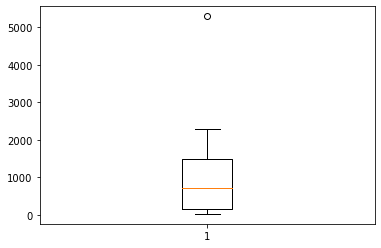

In [8]:
#Outliers: O outlier que vemos não é o valor da ordem de 3 mi, este valor que vemos da ordem de 5000
#faz sentido, e não consideraremos ele como um outlier, somente o valor de 3 mi.
plt.boxplot(dfProdutos["valor"][dfProdutos.valor < 3000000])
plt.show()
# A correção do outlier que também é o produto com nome ilegível, será feita subtituindo respectivamente o 
# valor e nome pela mediana e moda, diretamente na base de dados finais, onde vamos fundir todos os dados de
# vendas relevantes para a análise.

## 1.4 Consistência entre dados/bases: Chaves Primárias e Secundárias.

In [9]:
#Clientes: Inconsistência esperada.
np.unique(np.sort(dfVendas[~dfVendas["id_cliente"].isin(dfClientes.id)].id_cliente.values))
id_cliente_nulos
#Neste caso aparece como incosistência os registros que apaguei na base clientes, o que vamos 
# contornar abrindo mão deles na hora de fundir as bases.

#Lojas: Consistente.
dfVendas[~dfVendas["id_loja"].isin(dfLojas.id)]

#Produtos: Consistentes.
dfVendas[~dfVendas["id_produto"].isin(dfProdutos.id)]

#Pagamentos: Inconsistência esperada.
dfVendas[~dfVendas["id"].isin(dfPg["id_venda"])]
#Neste caso a inconsistência indica apenas que a venda não foi paga. Vamos deixar assim, e construir uma coluna
# para saber se a venda foi paga ou nâo.

,id,id_cliente,id_loja,id_produto,dt_venda
5,6,292,1,4,2020-01-29
6,7,87,3,3,2019-04-21
13,14,560,8,8,2018-07-28
45,46,501,4,2,2018-06-20
48,49,976,10,2,2019-05-16
...,...,...,...,...,...
958,959,860,9,9,2019-11-21
966,967,458,3,9,2018-07-31
984,985,360,5,3,2020-05-06
989,990,499,1,3,2019-08-24


In [10]:
# Corrigindo a inconsistência:
dfVendas = dfVendas[dfVendas["id_cliente"].isin(dfClientes.id)]

# 2 Data Fusion: Fusão das Bases de Dados.

## 2.1 Indexação das bases:

In [11]:
#Vamos definir index para todas as bases: 1,2,3...
dfClientes = dfClientes.set_index("id")
dfLojas = dfLojas.set_index("id")
dfPg = dfPg.set_index("id")
dfProdutos = dfProdutos.set_index("id")
dfVendas = dfVendas.set_index("id")

## 2.2 Fusão:

In [12]:
df = dfVendas.join(dfClientes.add_prefix("cliente_"), on="id_cliente")
df = df.join(dfLojas.add_prefix("loja_"), on="id_loja")
df = df.join(dfProdutos.add_prefix("prod_"), on="id_produto")
df = df.join(dfPg.set_index("id_venda"))

#Excluindo as chaves secundárias:
df.drop(df.iloc[:,[0,1,2]], axis=1, inplace=True)

# 3 Feature Engineering:

## 3.1 Correção do Produto Outlier:

In [13]:
#Produto Outlier:
prod_fora_padrao = dfProdutos.iloc[9,0]

#Produto moda e seu valor:
produto_moda = sts.mode(df["prod_produto"])
vlr_produto_moda = dfProdutos["valor"][dfProdutos["produto"] == produto_moda] 

#Substituição
df.loc[df["prod_produto"] == prod_fora_padrao, ["prod_produto","prod_valor" ]] = (produto_moda,vlr_produto_moda)

C:\Users\pedro\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 3.2 Criação de Novos Atributos:

In [14]:
#Quantos dias demorou para pagar:
df["temp_pg"] = (df["dt_pgto"] - df["dt_venda"]).dt.days

In [15]:
# Idade do cliente em anos:
df["idade_cliente"] = np.floor((pd.to_datetime('today') - df.cliente_dt_nasc)/np.timedelta64(1,'Y'))

In [16]:
#Venda paga (pg=1) ou não paga(pg=0):
df.loc[df["dt_pgto"].isnull(), "pg"] = 0
df.loc[~df["dt_pgto"].isnull(), "pg"] = 1

# 4 Análise Exploratória:

## 4.1 Quais lojas/produtos mais vendem e mais geram receitas em todo o período avaliado?

In [17]:
grafico1 = df[["loja_cidade","prod_valor"]].groupby(["loja_cidade"]).count()["prod_valor"].sort_values(ascending=False)
grafico2 = df[["loja_cidade","prod_valor"]].groupby(["loja_cidade"]).sum()["prod_valor"].sort_values(ascending=False)
grafico3 = df[["prod_produto", "prod_valor"]].groupby(["prod_produto"]).count().prod_valor.sort_values(ascending=False) 
grafico4 =  df[["prod_produto", "prod_valor"]].groupby(["prod_produto"]).sum().prod_valor.sort_values(ascending=False)

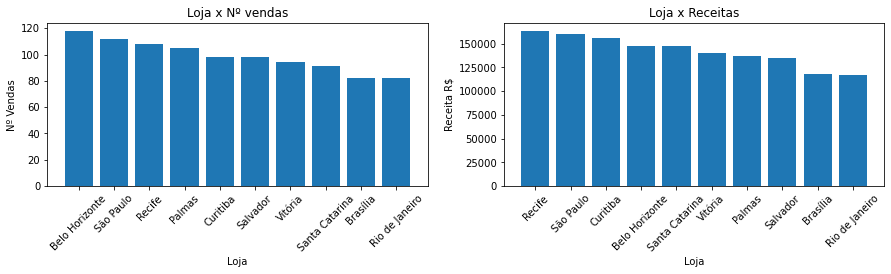

In [18]:
plt.subplots(figsize=(15,3))

plt.subplot(1,2,1)
plt.bar(grafico1.index, grafico1.values)
plt.title("Loja x Nº vendas")
plt.xticks(rotation=45)
plt.xlabel("Loja")
plt.ylabel("Nº Vendas")

plt.subplot(1,2,2)
plt.bar(grafico2.index, grafico2.values)
plt.title("Loja x Receitas")
plt.xticks(rotation=45)
plt.xlabel("Loja")
plt.ylabel("Receita R$")

plt.show()

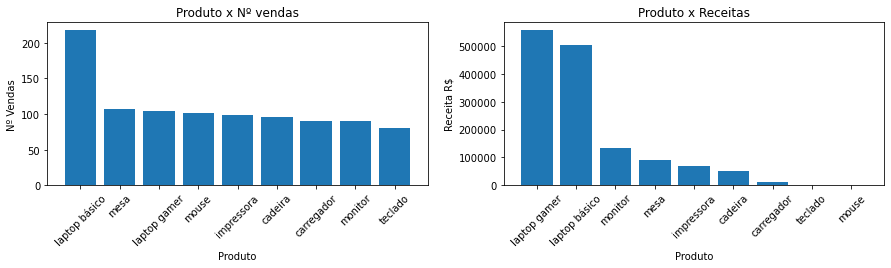

In [19]:
plt.subplots(figsize=(15,3))

plt.subplot(1,2,1)
plt.bar(grafico3.index, grafico3.values)
plt.title("Produto x Nº vendas")
plt.xticks(rotation=45)
plt.xlabel("Produto")
plt.ylabel("Nº Vendas")

plt.subplot(1,2,2)
plt.bar(grafico4.index, grafico4.values)
plt.title("Produto x Receitas")
plt.xticks(rotation=45)
plt.xlabel("Produto")
plt.ylabel("Receita R$")

plt.show()

## Resposta:
1) Loja com maior número de vendas: Belo Horizonte
2) Loja com maior receita: Recife
3) Produto mais vendido: Laptop Básico
4) Produto que gera maior receita: Laptop Gamer

## 4.2 Quais as lojas e produtos mais importantes do ponto de vista econômico?

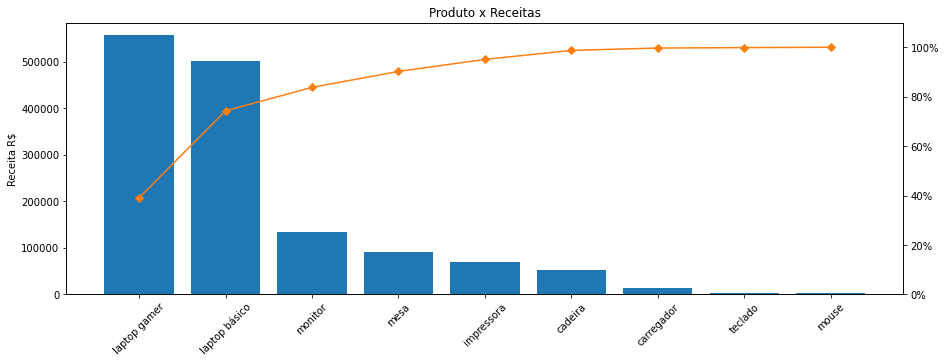

In [20]:
#Produto
fig, ax = plt.subplots(figsize=(15,5))

ax.bar(grafico4.index, grafico4.values)
plt.ylabel("Receita R$")
plt.xticks(rotation=45)
ax = ax.twinx() 
ax.plot(grafico4.index, grafico4.values.cumsum()/grafico4.values.sum()*100 ,color='C1', marker='D')
ax.yaxis.set_major_formatter(PercentFormatter())
plt.ylim(0,110)
plt.title("Produto x Receitas")
plt.xlabel("Loja")

plt.show()

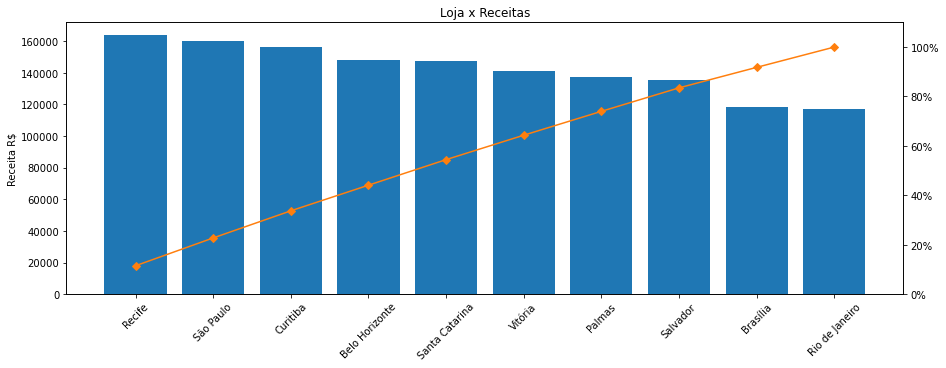

In [21]:
#Loja
fig, ax = plt.subplots(figsize=(15,5))

ax.bar(grafico2.index, grafico2.values)
plt.ylabel("Receita R$")
plt.xticks(rotation=45)
ax = ax.twinx() 
ax.plot(grafico2.index, grafico2.values.cumsum()/grafico2.values.sum()*100 ,color='C1', marker='D')
ax.yaxis.set_major_formatter(PercentFormatter())
plt.ylim(0,110)
plt.title("Loja x Receitas")
plt.xlabel("Loja")

plt.show()

## Resposta:
1) É nítido que praticamente 80% da receita é proveninete de somente dois produtos, o laptop gamer e o laptop básico.
2) A contribuição para a receita é bem distribuida entre as cidades, não há uma disparidade significativa.

## 4.3 Avaliando a receita como uma função das variaveis produto e loja: 
receita = f (produto, loja)

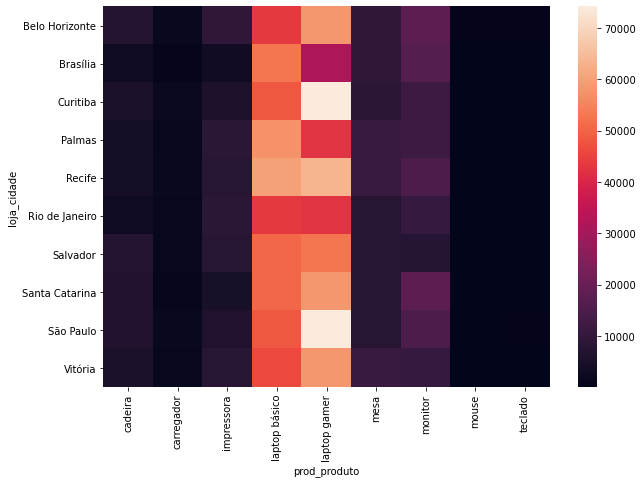

In [22]:
grafico = df[["loja_cidade","prod_produto","prod_valor"]].groupby(["loja_cidade","prod_produto"]).sum()
grafico = grafico.pivot_table(index='loja_cidade', columns='prod_produto', values='prod_valor', aggfunc='sum')

plt.figure(figsize=(10,7))
sns.heatmap(grafico)
plt.show()

## 4.4 Análises temporais:

## 4.4.1 Qual o tempo médio para ocorrer o pagamento das vendas?

In [23]:
#Tempo médio de pagamento:
dados = (df["temp_pg"][~df["temp_pg"].isnull()]).values
stats.describe(dados)
desvio_p = np.std(dados)
tempo_medio = np.mean(dados)
mediana = np.median(dados)
stats.shapiro(dados)

ShapiroResult(statistic=0.9487589597702026, pvalue=2.085217371570062e-16)

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

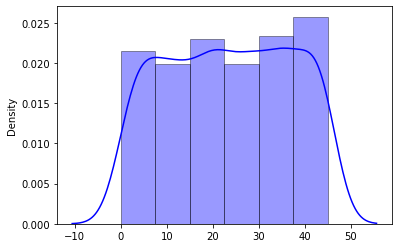

In [24]:
sns.distplot(dados, hist = True, kde = True,
             bins = 6, color = 'blue',
             hist_kws={'edgecolor': 'black'})

##  Resposta:
Como vemos pelo teste de hipótese Shapiro, a distribuição do tempo de pagamento não é Gaussiana, isso significa
que a média do tempo de pagamento (23 dias) não é significativa, o que fica evidente quando se olha o histograma acima. 

## 4.4.2 Existe algum padrão de vendas no tempo ? Tendência, Sazonalidade ?

- Receita x Tempo:

In [25]:
#Criando uma série temporal para as receitas:
ts_receita = df[["dt_venda","prod_valor"]].groupby(["dt_venda"]).sum().prod_valor

In [26]:
ts_ano = ts_receita.groupby(lambda x:x.year).sum()
ts_ano_mes = ts_receita.groupby([lambda x: x.year,lambda x: x.month]).sum()
ts_ano_mes18_19 = ts_receita["2018-01-04":"2019-12-31"].groupby([lambda x: x.year,lambda x: x.month]).sum()

- No periodo 2018-2019:

Vamos analisar se há sazonalidade, neste caso precisamos de ciclos completos, portanto vamos analisar 
somente os anos de 2018 e 2019.

In [27]:
dec = seasonal_decompose(ts_ano_mes18_19, period=12)
tend = dec.trend
sazo = dec.seasonal
err = dec.resid

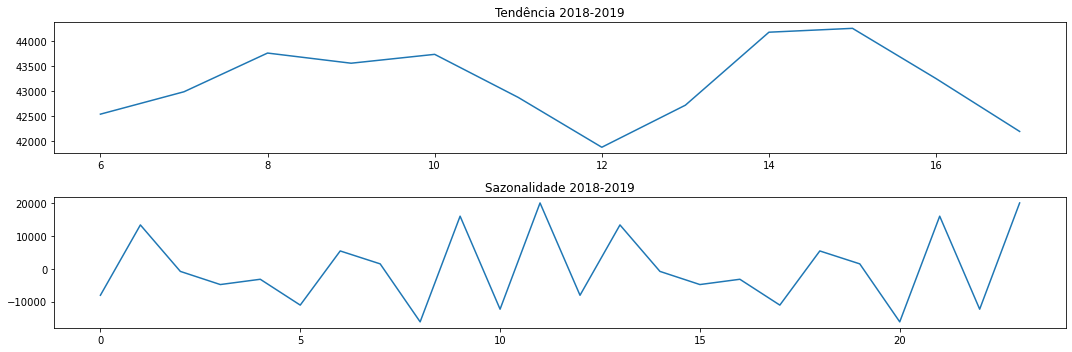

In [28]:
plt.subplots(figsize=(15,5))

plt.subplot(2,1,1)
plt.plot(tend.values)
plt.title("Tendência 2018-2019")

plt.subplot(2,1,2)
plt.plot(sazo.values)
plt.title("Sazonalidade 2018-2019")

plt.tight_layout()

## Resposta:
Não é possível identificar um padrão na tendência das vendas no período 2018-2019.
De forma geral há indícios de queda ao longo dos anos.
Quanto a sazonalidade, está se manifesta a cada ano da seguinte forma:
- Começo e final de ano as vendas são aquecidas, provavelmente devido as datas festivas e férias.
- Por volta do mês 6-7 as vendas ganham força novamente, provavelmente devido as férias escolares, uma vez
que os produtos que mais geram receitas são laptops (gamers e convencionais).

## 4.4.3 O que ocorre dentro de cada ano?

- Tendência ao longos dos anos:

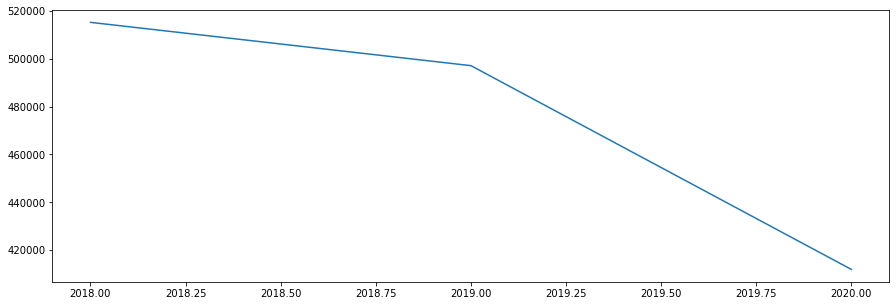

In [29]:
plt.figure(figsize=(15,5))
plt.plot(ts_ano)

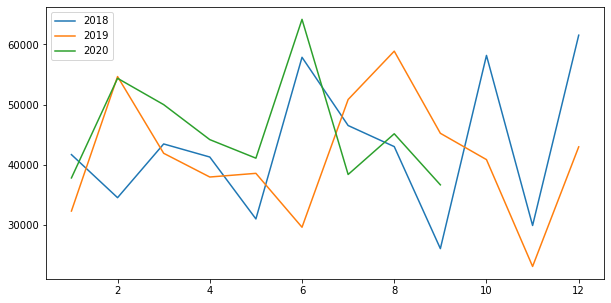

In [30]:
#Comportamento das vendas ao longos dos anos de 2018, 2019 e 2020
a = ts_ano_mes[2018]
b = ts_ano_mes[2019]
c = ts_ano_mes[2020]

fig, ax =  plt.subplots(figsize=(10,5))

ax.plot(a, label="2018")
ax.legend()

ax.plot(b, label="2019")
ax.legend()

ax.plot(c, label="2020")
ax.legend()

plt.show()

## Resposta:
- Vemos que o faturamento está seguindo uma tendência de queda a cada ano.
- O comportamendo das vendas em cada ano é semelhante, conforme haviamos visto na análise de sazonalidade.

## 4.5 Análise de Inadimplência:

## 4.5.1 Por loja:

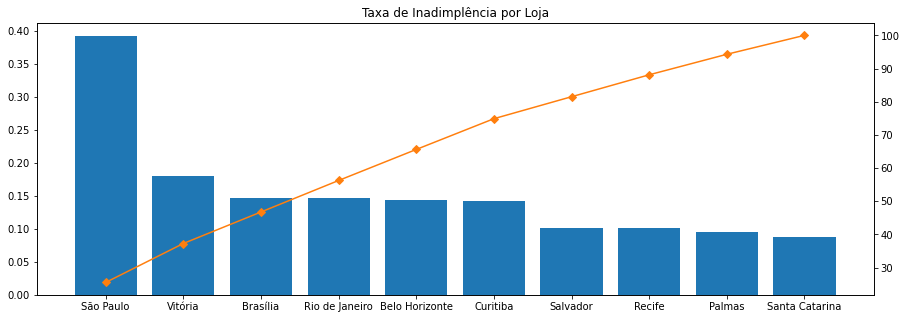

In [31]:
# Qual loja mais gera inadimplência?
numero_vendas =  df[["loja_cidade","prod_produto"]].groupby(["loja_cidade"]).count().prod_produto
numero_vendas_pagas = df[["loja_cidade", "pg"]][df["pg"] == 1].groupby(["loja_cidade"]).count().pg
tx_pagadores = numero_vendas_pagas/numero_vendas 
tx_inadimplecia = (1-tx_pagadores).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(tx_inadimplecia.index, tx_inadimplecia.values)
ax = ax.twinx().plot(tx_inadimplecia.index, tx_inadimplecia.values.cumsum()/tx_inadimplecia.sum()*100, color='C1', marker='D')
plt.title("Taxa de Inadimplência por Loja")
plt.show()

## 4.5.2 Por Produto

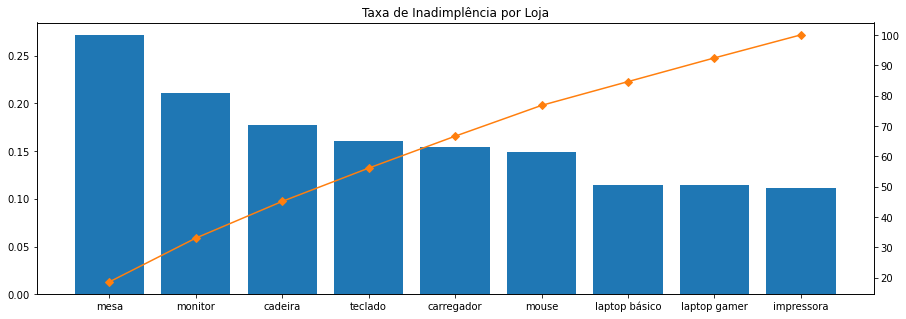

In [47]:
# Qual produto mais gera inadimplência?
numero_vendas =  df[["prod_valor","prod_produto"]].groupby(["prod_produto"]).count().prod_valor
numero_vendas_pagas = df[["prod_produto", "pg"]][df["pg"] == 1].groupby(["prod_produto"]).count().pg
tx_pagadores = numero_vendas_pagas/numero_vendas 
tx_inadimplecia = (1-tx_pagadores).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(tx_inadimplecia.index, tx_inadimplecia.values)
ax = ax.twinx().plot(tx_inadimplecia.index, tx_inadimplecia.values.cumsum()/tx_inadimplecia.sum()*100, color='C1', marker='D')
plt.title("Taxa de Inadimplência por Loja")
plt.show()

## 4.5.3 Por Idade:

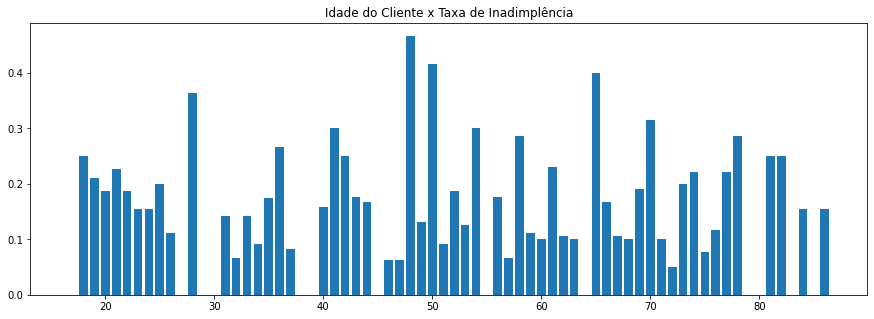

In [33]:
# Qual idade mais gera inadimplência?
numero_vendas =  df[["prod_valor","idade_cliente"]].groupby(["idade_cliente"]).count().prod_valor
numero_vendas_pagas = df[["pg","idade_cliente"]][df["pg"] == 1].groupby(["idade_cliente"]).count().pg
tx_pagadores = numero_vendas_pagas/numero_vendas 
tx_inadimplecia = (1-tx_pagadores)

plt.figure(figsize=(15,5))
plt.bar(tx_inadimplecia.index, tx_inadimplecia.values)
plt.title("Idade do Cliente x Taxa de Inadimplência")
plt.show()

## Resposta:
Vemos que:
- São Paulo ganha disparado como loja/cidade com mais inadimplência.
- A mesa ganha como produto com mais inadimplência.
- A idade em torno de 50 anos é a que mais gera inadimplência.

# 5 Machine Learning para Predição de Inadimplência:

## 5.1 Atributos:

In [34]:
dados = df[["cliente_sexo","idade_cliente","loja_cidade", "prod_produto","pg"]]
x = dados.iloc[:,0:4].values
y = dados.iloc[:,4].values

## 5.2 Codificação:

In [35]:
# Já estava codificado como Label Encoding, mas o modelo exige One-Hot Encondig:
onehot = OneHotEncoder(categories='auto', sparse=False)

x_sexo = onehot.fit_transform(x[:,0].reshape(-1,1))
x_sexo = x_sexo[:,0].reshape(-1,1)

x_loja = onehot.fit_transform(x[:,2].reshape(-1,1))
x_loja = x_loja[:,0:9]

x_prod = onehot.fit_transform(x[:,3].reshape(-1,1))
x_prod = x_prod[:, 0:8]

x_new= np.hstack((x_sexo, x[:,1].reshape(-1,1), x_loja, x_prod))

## 5.3 Normalização:

In [36]:
x_new[:,1] = (x_new[:,1]  - x_new[:,1] .min())/(x_new[:,1] .max() - x_new[:,1] .min())

## 5.4 Split: Divisão de dados entre treino e teste.

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size= 0.3, random_state = 0)

## 5.5 Modelos Convencionais de Machine Learning:

In [38]:
# Criação dos modelos convencionais:
lista_modelos = [GaussianNB(),
                 DecisionTreeClassifier(),
                 SVC(),
                 RandomForestClassifier(n_estimators = 500),
                 KNeighborsClassifier(n_neighbors=3),
                 XGBClassifier()
                ]
for modelo in lista_modelos:
    modelo.fit(x_train, y_train)

[17:02:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pedro\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## 5.6 Previsões com os modelos convencionais:

In [39]:
# Previsões: Hold-Out
previsoes = []
taxa_acerto = []
for modelo in lista_modelos:
    previsoes.append(modelo.predict(x_test))
    taxa_acerto.append(accuracy_score(y_test, previsoes[-1]))

## 5.7 Modelo Não Convencional: Rede Neural Perceptron Multicamadas.

In [40]:
# Correção exigida pelo Keras/TensorFlow:
x_train = x_train.astype(np.float)
y_train = y_train.astype(np.float)
x_test = x_test.astype(np.float)
y_test = y_test.astype(np.float)

In [41]:
# Modelo: 
modelo_classifier = Sequential()
modelo_classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_new.shape[1] ))
modelo_classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu'))
modelo_classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'softmax'))

#Compilação:
modelo_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Visualização da estrutura da rede neural:
modelo_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


In [42]:
#Treinamento:
modelo_classifier.fit(x_train, y_train, epochs=1000, verbose=False)

In [43]:
#Ajuste da saída do modelo:
y_pred = modelo_classifier.predict(x_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_pred_c = np.empty(shape=len(y_test)).reshape(-1,1)

for i in range(len(y_test)):
    y_pred_c[i,0] = 1 if y_pred[i,0] > 0.5 else 0

## 5.8 Métricas de Desempenho dos Modelos para Previsão de Inadimplência:

In [44]:
previsoes.append(y_pred_c)
taxa_acerto.append(accuracy_score(y_test, previsoes[-1]))

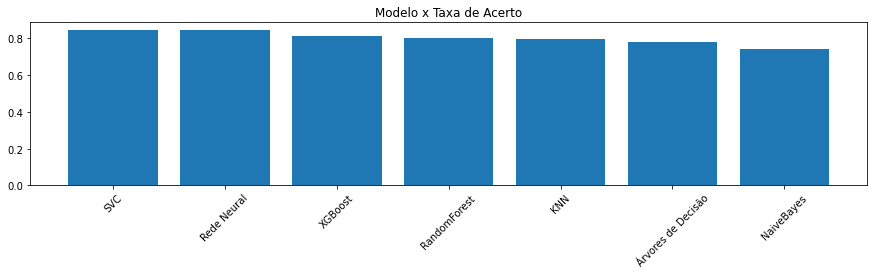

In [45]:
models = ["NaiveBayes", "Árvores de Decisão", "SVC", "RandomForest", "KNN","XGBoost", "Rede Neural"]
df_res = pd.DataFrame({"Modelos":models, "TxAcerto":taxa_acerto})
df_res = df_res.set_index("Modelos")
grafico = df_res.TxAcerto.sort_values(ascending=False)

plt.figure(figsize=(15,3))
plt.bar(grafico.index, grafico.values)
plt.title("Modelo x Taxa de Acerto")
plt.xticks(rotation=45)
plt.show()

In [46]:
df_res["TxAcerto"].sort_values(ascending=False)

Modelos
SVC                   0.845118
Rede Neural           0.845118
XGBoost               0.811448
RandomForest          0.804714
KNN                   0.797980
Árvores de Decisão    0.781145
NaiveBayes            0.744108
Name: TxAcerto, dtype: float64

## Resposta:
Os dois melhores modelos de predição foram:
- Redes Neurais Artificiais
- SVC (Suport Vector Machine)

Ambos os modelos com capacidade predizer a ocorrência de uma inadimplência com cerca de 85% de chances de acerto.